# Airbnb Rio - Previsão de Preço de Imóvel para pessoas comuns 

### Contexto

No Airbnb, qualquer pessoa que tenha um quarto ou um imóvel de qualquer tipo (apartamento, casa, chalé, pousada, etc.) pode ofertar o seu imóvel para ser alugado por diária.

Você cria o seu perfil de host (pessoa que disponibiliza um imóvel para aluguel por diária) e cria o anúncio do seu imóvel.

Nesse anúncio, o host deve descrever as características do imóvel da forma mais completa possível, de forma a ajudar os locadores/viajantes a escolherem o melhor imóvel para eles (e de forma a tornar o seu anúncio mais atrativo)

Existem dezenas de personalizações possíveis no seu anúncio, desde quantidade mínima de diária, preço, quantidade de quartos, até regras de cancelamento, taxa extra para hóspedes extras, exigência de verificação de identidade do locador, etc.

### Nosso objetivo

Construir um modelo de previsão de preço que permita uma pessoa comum que possui um imóvel possa saber quanto deve cobrar pela diária do seu imóvel.

Ou ainda, para o locador comum, dado o imóvel que ele está buscando, ajudar a saber se aquele imóvel está com preço atrativo (abaixo da média para imóveis com as mesmas características) ou não.

### O que temos disponível, inspirações e créditos

As bases de dados foram retiradas do site kaggle: https://www.kaggle.com/allanbruno/airbnb-rio-de-janeiro

Elas estão disponíveis para download abaixo da aula (se você puxar os dados direto do Kaggle pode ser que encontre resultados diferentes dos meus, afinal as bases de dados podem ter sido atualizadas).

Caso queira uma outra solução, podemos olhar como referência a solução do usuário Allan Bruno do kaggle no Notebook: https://www.kaggle.com/allanbruno/helping-regular-people-price-listings-on-airbnb

Você vai perceber semelhanças entre a solução que vamos desenvolver aqui e a dele, mas também algumas diferenças significativas no processo de construção do projeto.

- As bases de dados são os preços dos imóveis obtidos e suas respectivas características em cada mês.
- Os preços são dados em reais (R$)
- Temos bases de abril de 2018 a maio de 2020, com exceção de junho de 2018 que não possui base de dados

### Expectativas Iniciais

- Acredito que a sazonalidade pode ser um fator importante, visto que meses como dezembro costumam ser bem caros no RJ
- A localização do imóvel deve fazer muita diferença no preço, já que no Rio de Janeiro a localização pode mudar completamente as características do lugar (segurança, beleza natural, pontos turísticos)
- Adicionais/Comodidades podem ter um impacto significativo, visto que temos muitos prédios e casas antigos no Rio de Janeiro

Vamos descobrir o quanto esses fatores impactam e se temos outros fatores não tão intuitivos que são extremamente importantes.

### Importar Bibliotecas e Bases de Dados

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pathlib

##### Os meses no dataset podem ser identificados pelas primeiras três letras e o ano de cada arquivo pode ser identificado pelos quatro últimos caracteres de cada arquivo (sem considerar a extensão).


In [2]:
meses = {'jan': 1, 'fev':2, 'mar':3, 'abr': 4, 'mai':5, 'jun': 6, 'jul': 7, 'ago': 8, 'set': 9, 'out': 10, 'nov': 11, 'dez': 12}

caminho_bases = pathlib.Path('dataset')

base_airbnb = pd.DataFrame()

for arquivo in caminho_bases.iterdir():
    nome_mes = arquivo.name[:3]
    mes = meses[nome_mes]
    
    ano = arquivo.name[-8:]
    ano = int(ano.replace('.csv', ''))
    
    df = pd.read_csv(caminho_bases / arquivo.name, low_memory=False)
    df['ano'] = ano
    df['mes'] = mes
    base_airbnb = base_airbnb.append(df)

display(base_airbnb)

id                            listing_url       scrape_id  \
0         14063     https://www.airbnb.com/rooms/14063  20180414160018   
1         17878     https://www.airbnb.com/rooms/17878  20180414160018   
2         24480     https://www.airbnb.com/rooms/24480  20180414160018   
3         25026     https://www.airbnb.com/rooms/25026  20180414160018   
4         31560     https://www.airbnb.com/rooms/31560  20180414160018   
...         ...                                    ...             ...   
34324  38844730  https://www.airbnb.com/rooms/38844730  20190923212307   
34325  38846408  https://www.airbnb.com/rooms/38846408  20190923212307   
34326  38846703  https://www.airbnb.com/rooms/38846703  20190923212307   
34327  38847050  https://www.airbnb.com/rooms/38847050  20190923212307   
34328  38847655  https://www.airbnb.com/rooms/38847655  20190923212307   

      last_scraped                                          name  \
0       2018-04-14                          Living in a Postcard   
1       2018-04-14             Very Nice 2Br - Copacabana - WiFi   
2       2018-04-14              Nice and cozy near Ipanema Beach   
3       2018-04-14     Beautiful Modern Decorated Studio in Copa   
4       2018-04-14              NICE & COZY 1BDR - IPANEMA BEACH   
...            ...                                           ...   
34324   2019-09-24             TRANSAMERICA BARRA DA TIJUCA R IV   
34325   2019-09-24                      Alugo para o Rock in Rio   
34326   2019-09-24  Apt COMPLETO em COPACABANA c/TOTAL SEGURANÇA   
34327   2019-09-24                     Cobertura Cinematografica   
34328   2019-09-24     Quarto em cobertura em frente à praia III   

                                                 summary  \
0      Besides the most iconic's view, our apartment ...   
1      Please note that special rates apply for New Y...   
2      My studio is located in the best  of Ipanema. ...   
3      Our apartment is a little gem, everyone loves ...   
4      This nice and clean 1 bedroom apartment is loc...   
...                                                  ...   
34324  Em estilo contemporâneo, o Transamerica Prime ...   
34325  Confortável apartamento, 2 quartos , sendo 1 s...   
34326  Apartamento quarto e sala COMPLETO para curtas...   
34327                               Cobertura alto nivel   
34328  Quarto em cobertura quadriplex com vista lindí...   

                                                   space  \
0                                                    NaN   
1      - large balcony which looks out on pedestrian ...   
2      The studio is located at Vinicius de Moraes St...   
3      This newly renovated studio (last renovations ...   
4      This nice and clean 1 bedroom apartment is loc...   
...                                                  ...   
34324                                                NaN   
34325  O apartamento estará com mobília completa disp...   
34326  Espaço ideal para até 5 pessoas. Cama de casal...   
34327                                                NaN   
34328                                                NaN   

                                             description experiences_offered  \
0      Besides the most iconic's view, our apartment ...                none   
1      Please note that special rates apply for New Y...                none   
2      My studio is located in the best  of Ipanema. ...                none   
3      Our apartment is a little gem, everyone loves ...                none   
4      This nice and clean 1 bedroom apartment is loc...                none   
...                                                  ...                 ...   
34324  Em estilo contemporâneo, o Transamerica Prime ...                none   
34325  Confortável apartamento, 2 quartos , sendo 1 s...                none   
34326  Apartamento quarto e sala COMPLETO para curtas...                none   
34327                               Cobertura alto nivel         

- A limpeza de colunas nesse DF é essencial e de suma importância. Um modelo com excesso de colunas pode atrapalhar a classificação e previsão na hora de rodar o modelo

- A fim de ver quais colunas são ou não relevantes, foi criado um arquivo excel com as primeiras 500 linhas para uma análise qualitativa primária.

In [3]:
print(list(base_airbnb.columns))

['id', 'listing_url', 'scrape_id', 'last_scraped', 'name', 'summary', 'space', 'description', 'experiences_offered', 'neighborhood_overview', 'notes', 'transit', 'access', 'interaction', 'house_rules', 'thumbnail_url', 'medium_url', 'picture_url', 'xl_picture_url', 'host_id', 'host_url', 'host_name', 'host_since', 'host_location', 'host_about', 'host_response_time', 'host_response_rate', 'host_acceptance_rate', 'host_is_superhost', 'host_thumbnail_url', 'host_picture_url', 'host_neighbourhood', 'host_listings_count', 'host_total_listings_count', 'host_verifications', 'host_has_profile_pic', 'host_identity_verified', 'street', 'neighbourhood', 'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'city', 'state', 'zipcode', 'market', 'smart_location', 'country_code', 'country', 'latitude', 'longitude', 'is_location_exact', 'property_type', 'room_type', 'accommodates', 'bathrooms', 'bedrooms', 'beds', 'bed_type', 'amenities', 'square_feet', 'price', 'weekly_price', 'monthly_price', '

In [4]:
base_airbnb.head(500).to_csv('1a_análise_cols.csv', sep=';')

## Limpeza das Colunas
##### Critérios para exclusão de colunas e limpeza do dataframe:
- Muitas colunas não possuem informações suficiente (ou nenhuma) a ponto de serem significativas para um modelo preditivo.
- Portanto, algumas 'classes' de colunas são propensas a serem removida do dataframe principal:
    1. Colunas repetidas ou muito similares
    2. Colunas que apresentam descrições e texto livre
    3. Colunas nulas que não possuem nenhuma informação
    4. Colunas de IDs e links irrelevantes
- Todas essas análises das colunas foram feitas no arquivo excel acima criado e foram removidas e transformadas num novo dataframe.

In [5]:
n_m_q = base_airbnb['square_feet'].isnull().sum() # quantidade de valores nulos

pct_n_m_q = n_m_q / len(base_airbnb['square_feet'])

print(n_m_q)
print('{:.2%}'.format(pct_n_m_q))

# 98.5% dos valores desta coluna são nulos.

888162
98.44%


In [6]:
df_airbnb = base_airbnb.drop(['id', 'listing_url', 'scrape_id', 'last_scraped', 'name', 'summary', 'space', 'description',
                             'experiences_offered', 'neighborhood_overview', 'notes', 'transit', 'access', 'interaction',
                             'house_rules', 'thumbnail_url', 'medium_url', 'picture_url', 'xl_picture_url',
                             'host_id', 'host_url', 'host_name', 'host_location', 'host_about', 'host_thumbnail_url',
                             'host_picture_url', 'host_neighbourhood', 'host_verifications', 'host_has_profile_pic',
                             'street', 'neighbourhood', 'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'city',
                             'state', 'zipcode', 'market', 'smart_location', 'country_code', 'country', 'is_location_exact',
                             'square_feet', 'weekly_price', 'monthly_price', 'calendar_updated', 'has_availability',
                             'availability_30', 'availability_60', 'availability_90', 'availability_365', 'calendar_last_scraped',
                             'first_review', 'last_review', 'requires_license', 'license', 'jurisdiction_names', 'require_guest_profile_picture', 'require_guest_phone_verification',
                             'calculated_host_listings_count', 'reviews_per_month', 'minimum_minimum_nights', 
                             'maximum_minimum_nights', 'minimum_maximum_nights', 'maximum_maximum_nights', 
                             'minimum_nights_avg_ntm', 'maximum_nights_avg_ntm', 'number_of_reviews_ltm', 
                             'calculated_host_listings_count_entire_homes', 'calculated_host_listings_count_private_rooms', 
                             'calculated_host_listings_count_shared_rooms', 'host_since'], axis=1)
display(df_airbnb)

host_response_time host_response_rate host_acceptance_rate  \
0                     NaN                NaN                  NaN   
1          within an hour               100%                  NaN   
2          within an hour               100%                  NaN   
3          within an hour               100%                  NaN   
4          within an hour               100%                  NaN   
...                   ...                ...                  ...   
34324      within an hour                93%                  NaN   
34325                 NaN                NaN                  NaN   
34326  within a few hours                74%                  NaN   
34327                 NaN                NaN                  NaN   
34328  a few days or more                38%                  NaN   

      host_is_superhost  host_listings_count  host_total_listings_count  \
0                     f                  1.0                        1.0   
1                     t                  2.0                        2.0   
2                     f                  1.0                        1.0   
3                     f                  3.0                        3.0   
4                     t                  1.0                        1.0   
...                 ...                  ...                        ...   
34324                 f                  0.0                        0.0   
34325                 f                  0.0                        0.0   
34326                 f                 32.0                       32.0   
34327                 f                  0.0                        0.0   
34328                 f                  5.0                        5.0   

      host_identity_verified   latitude  longitude property_type  ...  \
0                          t -22.946854 -43.182737     Apartment  ...   
1                          f -22.965919 -43.178962   Condominium  ...   
2                          t -22.985698 -43.201935     Apartment  ...   
3                          t -22.977117 -43.190454     Apartment  ...   
4                          t -22.983024 -43.214270     Apartment  ...   
...                      ...        ...        ...           ...  ...   
34324                      f -23.003180 -43.342840     Apartment  ...   
34325                      f -22.966640 -43.393450     Apartment  ...   
34326                      t -22.962080 -43.175520     Apartment  ...   
34327                      t -23.003400 -43.341820     Apartment  ...   
34328                      f -23.010560 -43.363350     Apartment  ...   

      review_scores_cleanliness  review_scores_checkin  \
0                           9.0                    9.0   
1                           9.0                   10.0   
2                          10.0                   10.0   
3                          10.0                   10.0   
4                          10.0                   10.0   
...                         ...                    ...   
34324                       NaN                    NaN   
34325                       NaN                    NaN   
34326                       NaN                    NaN   
34327                       NaN                    NaN   
34328                       NaN                    NaN   

       review_scores_communication  review_scores_location  \
0                              9.0                     9.0   
1                             10.0                     9.0   
2                             10.0                    10.0   
3                             10.0                    10.0   
4                             10.0                    10.0   
...                            ...                     ...   
34324                          NaN                     NaN   
34325                          NaN                     NaN   
34326                          NaN                     NaN   
34327                          NaN                     NaN   
34328                

In [7]:
df_airbnb['host_acceptance_rate'].isnull().sum() / len(df_airbnb['host_acceptance_rate']) * 100

# quase 90% dos valores desta coluna são nulos. Drop nela!

89.49889715254763

In [8]:
print('Porcentagem de valores nulos por coluna:\n')
for coluna in df_airbnb:
    col_n_sum = df_airbnb[coluna].isnull().sum()
    pct = round((col_n_sum / len(df_airbnb)*100), 2)
    print('{}: {}%'.format(coluna, pct))

Porcentagem de valores nulos por coluna:

host_response_time: 44.54%
host_response_rate: 44.54%
host_acceptance_rate: 89.5%
host_is_superhost: 0.05%
host_listings_count: 0.05%
host_total_listings_count: 0.05%
host_identity_verified: 0.05%
latitude: 0.0%
longitude: 0.0%
property_type: 0.0%
room_type: 0.0%
accommodates: 0.0%
bathrooms: 0.19%
bedrooms: 0.09%
beds: 0.28%
bed_type: 0.0%
amenities: 0.0%
price: 0.0%
security_deposit: 46.69%
cleaning_fee: 34.75%
guests_included: 0.0%
extra_people: 0.0%
minimum_nights: 0.0%
maximum_nights: 0.0%
number_of_reviews: 0.0%
review_scores_rating: 49.66%
review_scores_accuracy: 49.72%
review_scores_cleanliness: 49.7%
review_scores_checkin: 49.73%
review_scores_communication: 49.7%
review_scores_location: 49.72%
review_scores_value: 49.72%
instant_bookable: 0.0%
is_business_travel_ready: 0.0%
cancellation_policy: 0.0%
ano: 0.0%
mes: 0.0%


In [9]:
# muitas colunas possuem valores nulos com mais de 30%. O limite de 34.75 parece ótimo para estipular quais colunas deverão ou
# não serem removidas

for coluna in df_airbnb:
    col_n_sum = df_airbnb[coluna].isnull().sum()
    pct = round((col_n_sum / len(df_airbnb)*100), 2)
    if pct > 34.70:
        df_airbnb = df_airbnb.drop(coluna, axis=1)
        
display(df_airbnb)

host_is_superhost  host_listings_count  host_total_listings_count  \
0                     f                  1.0                        1.0   
1                     t                  2.0                        2.0   
2                     f                  1.0                        1.0   
3                     f                  3.0                        3.0   
4                     t                  1.0                        1.0   
...                 ...                  ...                        ...   
34324                 f                  0.0                        0.0   
34325                 f                  0.0                        0.0   
34326                 f                 32.0                       32.0   
34327                 f                  0.0                        0.0   
34328                 f                  5.0                        5.0   

      host_identity_verified   latitude  longitude property_type  \
0                          t -22.946854 -43.182737     Apartment   
1                          f -22.965919 -43.178962   Condominium   
2                          t -22.985698 -43.201935     Apartment   
3                          t -22.977117 -43.190454     Apartment   
4                          t -22.983024 -43.214270     Apartment   
...                      ...        ...        ...           ...   
34324                      f -23.003180 -43.342840     Apartment   
34325                      f -22.966640 -43.393450     Apartment   
34326                      t -22.962080 -43.175520     Apartment   
34327                      t -23.003400 -43.341820     Apartment   
34328                      f -23.010560 -43.363350     Apartment   

             room_type  accommodates  bathrooms  ...  guests_included  \
0      Entire home/apt             4        1.0  ...                2   
1      Entire home/apt             5        1.0  ...                2   
2      Entire home/apt             2        1.0  ...                2   
3      Entire home/apt             3        1.0  ...                2   
4      Entire home/apt             3        1.0  ...                2   
...                ...           ...        ...  ...              ...   
34324  Entire home/apt             4        1.0  ...                2   
34325  Entire home/apt             4        2.0  ...                1   
34326  Entire home/apt             5        1.0  ...                3   
34327  Entire home/apt             4        1.0  ...                1   
34328     Private room             2        0.0  ...                2   

       extra_people minimum_nights maximum_nights number_of_reviews  \
0            $34.00             60            365                38   
1            $51.00              4             90               205   
2           $215.00              3             90                85   
3            $45.00              4             30               208   
4            $68.00              2           1125               200   
...             ...            ...            ...               ...   
34324        $50.00              1           1125                 0   
34325         $0.00              2           1125                 0   
34326        $30.00              3           1125                 0   
34327         $0.00              1           1125                 0   
34328        $80.00              1             30                 0   

       instant_bookable is_business_travel_ready          cancellation_policy  \
0                     f                        f  strict_14_with_grace_period   
1                     t                        f                       strict   
2                     f                        f                       strict   
3                     f                        f                       strict   
4                     t                        f                       strict   
...                 ...                      ...                        

#### As colunas que apresentavam mais ou quase metade do total de informações foram excluídas.
#### Obviamente poderíamos tê-las preenchido com "0" ou a média do total de linhas, mas isso implicaria numa análise muito enviesada devido à grande quantidade de valores ausentes.

- As colunas restantes que apresentam linhas com valores nulos são muito poucas, comparados com a totalidade de linhas. Portanto, podem-se excluir estas linhas sem ter uma perda significativa e tendo pouca alteração ou influência para os modelos.

In [10]:
df_airbnb = df_airbnb.dropna()
df_airbnb.isnull().sum(), df_airbnb.shape

(host_is_superhost            0
 host_listings_count          0
 host_total_listings_count    0
 host_identity_verified       0
 latitude                     0
 longitude                    0
 property_type                0
 room_type                    0
 accommodates                 0
 bathrooms                    0
 bedrooms                     0
 beds                         0
 bed_type                     0
 amenities                    0
 price                        0
 guests_included              0
 extra_people                 0
 minimum_nights               0
 maximum_nights               0
 number_of_reviews            0
 instant_bookable             0
 is_business_travel_ready     0
 cancellation_policy          0
 ano                          0
 mes                          0
 dtype: int64,
 (897709, 25))

In [11]:
print(df_airbnb.dtypes)
print('.' *85)
print(df_airbnb.iloc[0])

host_is_superhost             object
host_listings_count          float64
host_total_listings_count    float64
host_identity_verified        object
latitude                     float64
longitude                    float64
property_type                 object
room_type                     object
accommodates                   int64
bathrooms                    float64
bedrooms                     float64
beds                         float64
bed_type                      object
amenities                     object
price                         object
guests_included                int64
extra_people                  object
minimum_nights                 int64
maximum_nights                 int64
number_of_reviews              int64
instant_bookable              object
is_business_travel_ready      object
cancellation_policy           object
ano                            int64
mes                            int64
dtype: object
.............................................................

In [12]:
df_airbnb['price'] = df_airbnb['price'].str.replace('$', '')
df_airbnb['price'] = df_airbnb['price'].str.replace(',', '')
df_airbnb['price'] = df_airbnb['price'].astype(np.float32, copy=False)

df_airbnb['extra_people'] = df_airbnb['extra_people'].str.replace('$', '')
df_airbnb['extra_people'] = df_airbnb['extra_people'].str.replace(',', '')
df_airbnb['extra_people'] = df_airbnb['extra_people'].astype(np.float32, copy=False)



C:\Users\gabri\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
  """Entry point for launching an IPython kernel.
C:\Users\gabri\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
  """


In [13]:
print(df_airbnb.dtypes)


host_is_superhost             object
host_listings_count          float64
host_total_listings_count    float64
host_identity_verified        object
latitude                     float64
longitude                    float64
property_type                 object
room_type                     object
accommodates                   int64
bathrooms                    float64
bedrooms                     float64
beds                         float64
bed_type                      object
amenities                     object
price                        float32
guests_included                int64
extra_people                 float32
minimum_nights                 int64
maximum_nights                 int64
number_of_reviews              int64
instant_bookable              object
is_business_travel_ready      object
cancellation_policy           object
ano                            int64
mes                            int64
dtype: object


### Consolidar Base de Dados

### Se tivermos muitas colunas, já vamos identificar quais colunas podemos excluir

### Tratar Valores Faltando

### Verificar Tipos de Dados em cada coluna

### Análise Exploratória e Tratar Outliers

In [14]:
df_airbnb.corr()

host_listings_count  host_total_listings_count  \
host_listings_count                   1.000000                   1.000000   
host_total_listings_count             1.000000                   1.000000   
latitude                             -0.034115                  -0.034115   
longitude                             0.063635                   0.063635   
accommodates                          0.069320                   0.069320   
bathrooms                             0.022332                   0.022332   
bedrooms                              0.039712                   0.039712   
beds                                  0.042788                   0.042788   
price                                 0.092306                   0.092306   
guests_included                       0.041932                   0.041932   
extra_people                         -0.031589                  -0.031589   
minimum_nights                       -0.006441                  -0.006441   
maximum_nights                       -0.000100                  -0.000100   
number_of_reviews                    -0.025974                  -0.025974   
ano                                   0.031802                   0.031802   
mes                                  -0.009584                  -0.009584   

                           latitude  longitude  accommodates  bathrooms  \
host_listings_count       -0.034115   0.063635      0.069320   0.022332   
host_total_listings_count -0.034115   0.063635      0.069320   0.022332   
latitude                   1.000000   0.370416     -0.142082  -0.169135   
longitude                  0.370416   1.000000     -0.121746  -0.170504   
accommodates              -0.142082  -0.121746      1.000000   0.521909   
bathrooms                 -0.169135  -0.170504      0.521909   1.000000   
bedrooms                  -0.165050  -0.186332      0.675913   0.631544   
beds                      -0.113931  -0.110392      0.692740   0.491525   
price                     -0.092437  -0.085526      0.269929   0.310847   
guests_included           -0.091123   0.049375      0.317563   0.171695   
extra_people              -0.041113   0.001723      0.078709   0.077831   
minimum_nights            -0.016090  -0.019213      0.024583   0.035884   
maximum_nights            -0.001386   0.003403     -0.004242  -0.000780   
number_of_reviews         -0.046044   0.135377     -0.029873  -0.069505   
ano                        0.002595   0.012589     -0.000808  -0.009636   
mes                        0.002358  -0.007981     -0.003446   0.003829   

                           bedrooms      beds     price  guests_included  \
host_listings_count        0.039712  0.042788  0.092306         0.041932   
host_total_listings_count  0.039712  0.042788  0.092306         0.041932   
latitude                  -0.165050 -0.113931 -0.092437        -0.091123   
longitude                 -0.186332 -0.110392 -0.085526         0.049375   
accommodates               0.675913  0.692740  0.269929         0.317563   
bathrooms                  0.631544  0.491525  0.310847         0.171695   
bedrooms                   1.000000  0.625313  0.321678         0.259657   
beds                       0.625313  1.000000  0.204713         0.278757   
price                      0.321678  0.204713  1.000000         0.032171   
guests_included            0.259657  0.278757  0.032171         1.000000   
extra_people               0.078900  0.077806  0.044735         0.290723   
minimum_nights             0.036767  0.017696  0.027418         0.005280   
maximum_nights            -0.002110 -0.003065 -0.001142        -0.000817   
number_of_reviews         -0.083678 -0.021365 -0.078023         0.113160   
ano                       -0.007163 -0.012212  0.017889         0.027499   
mes                        0.002786  0.000399 -0.003071        -0.007374   

                           extra_people  minimum_nights  maximum_nights  \
host_listings_count           -0.031589       -0.006441       -0.000100  

In [15]:
# Duas colunas são idênticas, possuem uma correlação de 1. Vamos eliminar uma delas.
df_airbnb = df_airbnb.drop(['host_total_listings_count'], axis=1)

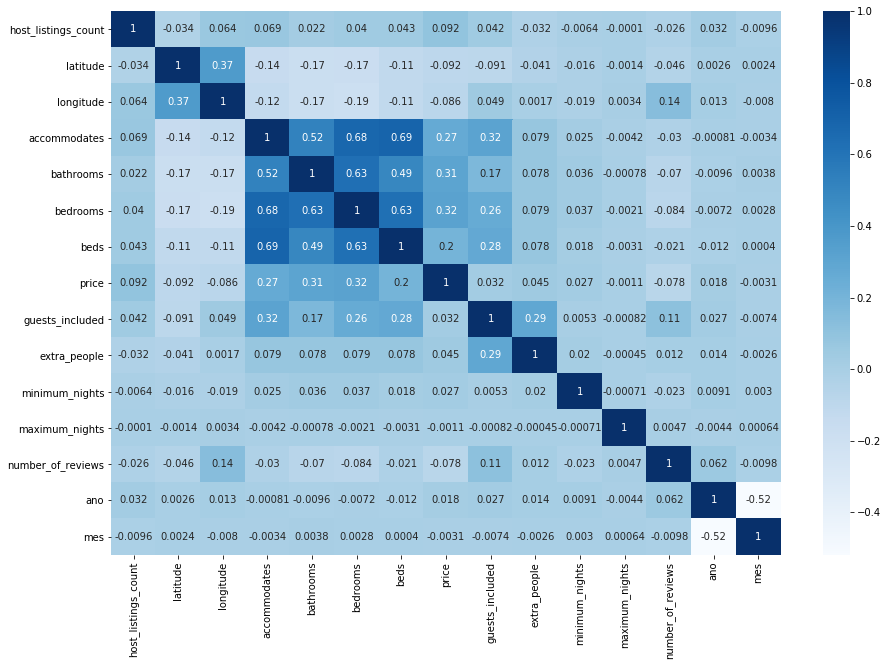

In [16]:
plt.figure(figsize=(15,10))
sns.heatmap(df_airbnb.corr(), annot=True, cmap='Blues')


### O intuito é tentar reconhecer os outliers em cada coluna para ter uma melhor noção e estabelecer limites para a análise através dos quartis.

In [17]:
def limites(coluna):
    q1 = coluna.quantile(0.25)
    q3 = coluna.quantile(0.75)
    amp = q3 - q1
    return q1 - 1.5 * amp, q3 + 1.5 * amp

def excluir_outliers(df, nome_coluna):
    qtde_linhas = df.shape[0]
    lim_inf, lim_sup = limites(df[nome_coluna])
    df = df.loc[(df[nome_coluna] >= lim_inf) & (df[nome_coluna] <= lim_sup), :]
    linhas_removidas = qtde_linhas - df.shape[0]
    return df,  linhas_removidas

In [18]:
limites(df_airbnb['price'])

(-524.0, 1276.0)

In [19]:
def diagrama_caixa(coluna):
    fig, (ax1, ax2) = plt.subplots(1,2)
    fig.set_size_inches(15,5)
    
    sns.boxplot(x=coluna, ax=ax1)
    ax2.set_xlim(limites(coluna))
    sns.boxplot(x=coluna, ax=ax2)

def histograma(coluna):
    plt.figure(figsize=(15,5))
    sns.distplot(coluna)

def grafico_barra(coluna):  
    plt.figure(figsize=(15, 5))
    ax = sns.barplot(x=coluna.value_counts().index, y=coluna.value_counts())
    ax.set_xlim(limites(coluna))

### Price

C:\Users\gabri\Anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


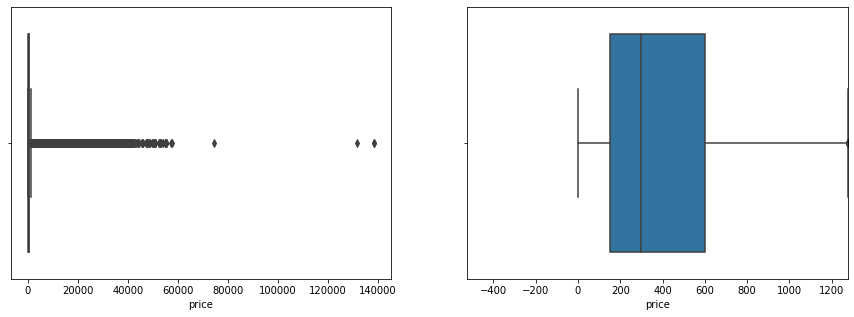

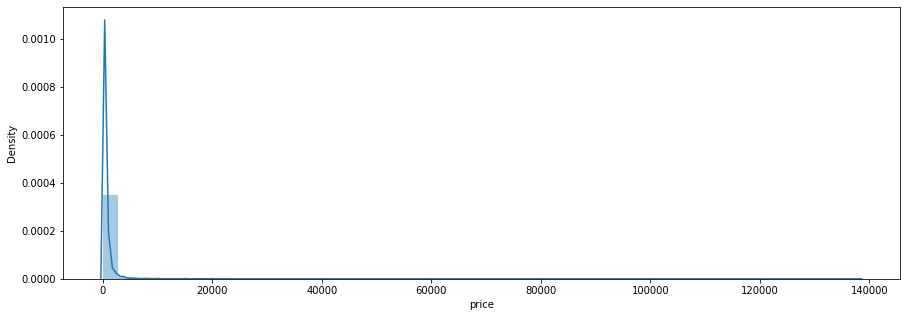

In [20]:
diagrama_caixa(df_airbnb['price'])
histograma(df_airbnb['price'])


In [21]:
df_airbnb, linhas_removidas = excluir_outliers(df_airbnb, 'price')
print('{} linhas removidas'.format(linhas_removidas))

87282 linhas removidas


- Como estamos construindo um modelo para imóveis comuns, acredito que os valores acima do limite superior serão apenas de apartamentos de altíssimo luxo, que não é o nosso objetivo principal. Por isso, podemos excluir esses outliers.

C:\Users\gabri\Anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


(810427, 24)


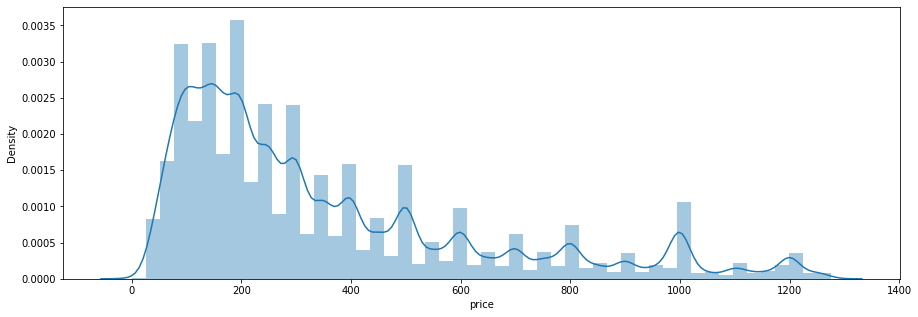

In [22]:
histograma(df_airbnb['price'])
print(df_airbnb.shape)

### extra_people
- Esta feature representa o valor cobrado por cada pessoa a mais que fique no imóvel.

C:\Users\gabri\Anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


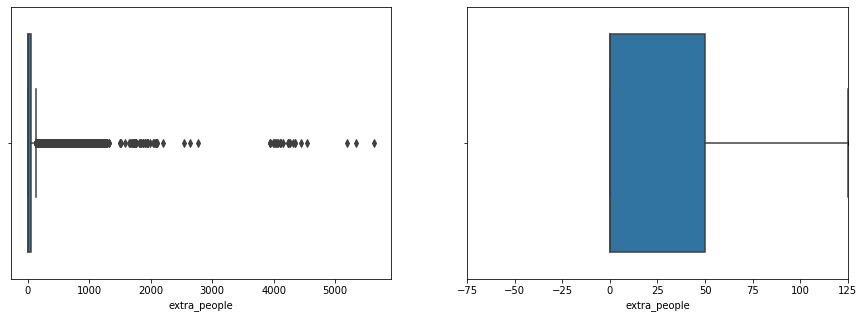

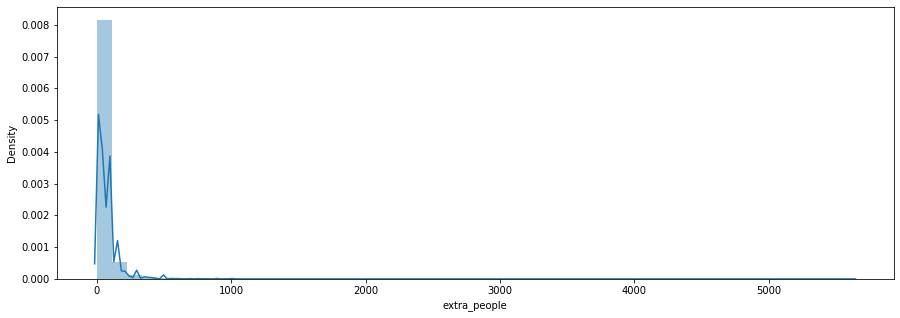

In [23]:
diagrama_caixa(df_airbnb['extra_people'])
histograma(df_airbnb['extra_people'])

In [24]:
df_airbnb, linhas_removidas = excluir_outliers(df_airbnb, 'extra_people')
print('{} linhas removidas'.format(linhas_removidas))

59194 linhas removidas


C:\Users\gabri\Anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


(751233, 24)


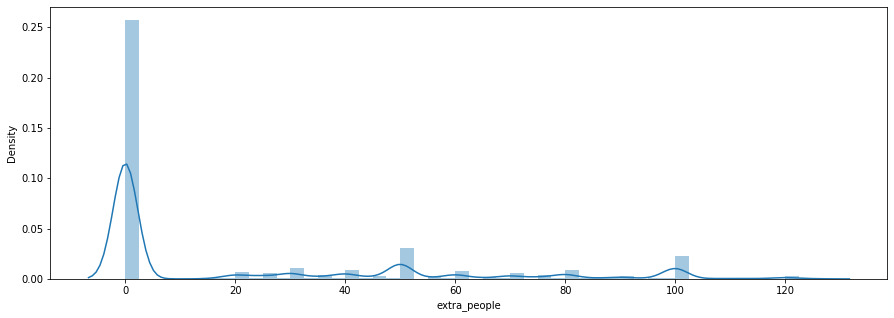

In [25]:
histograma(df_airbnb['extra_people'])
print(df_airbnb.shape)

### host_listing_count
- Essa feature é o número total de imóveis que o hosting tem no site.

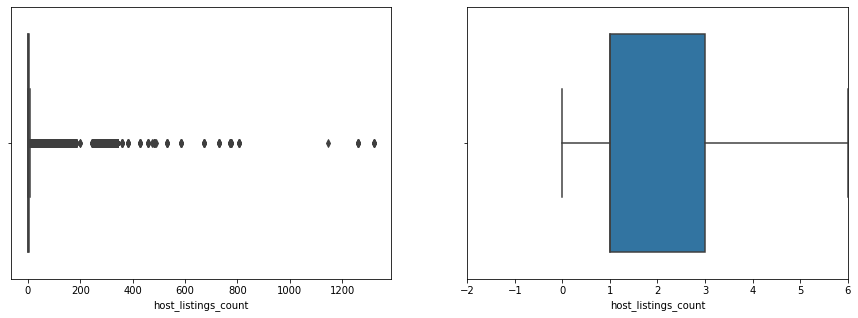

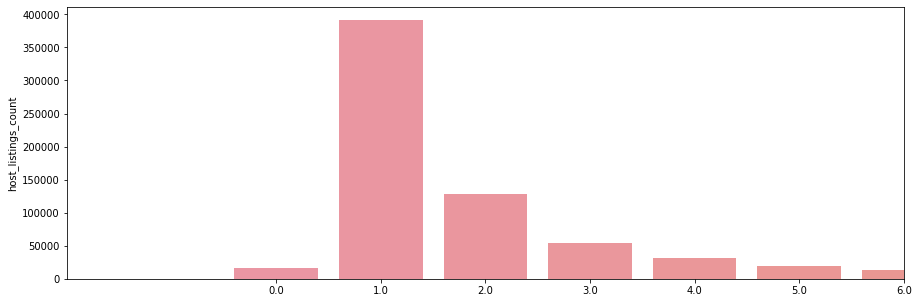

In [26]:
diagrama_caixa(df_airbnb['host_listings_count'])
grafico_barra(df_airbnb['host_listings_count'])

In [27]:
df_airbnb, linhas_removidas = excluir_outliers(df_airbnb, 'host_listings_count')
print('{} linhas removidas'.format(linhas_removidas))

97723 linhas removidas


- É possível remover esses outliers sem dano, uma vez que pessoas que possuem mais de 6 imóveis disponíveis no site porvavelmente são imobiliárias e, portanto, fogem do escopo do projeto não sendo um público alvo.

### accommodates
- Esta feature mostra o número total de pessoas que podem se acomodar no imóvel

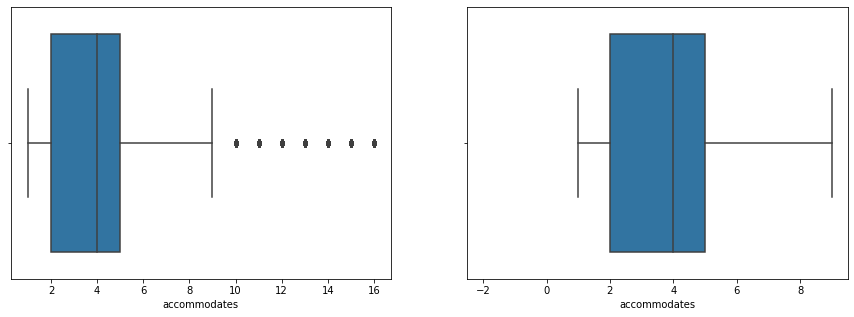

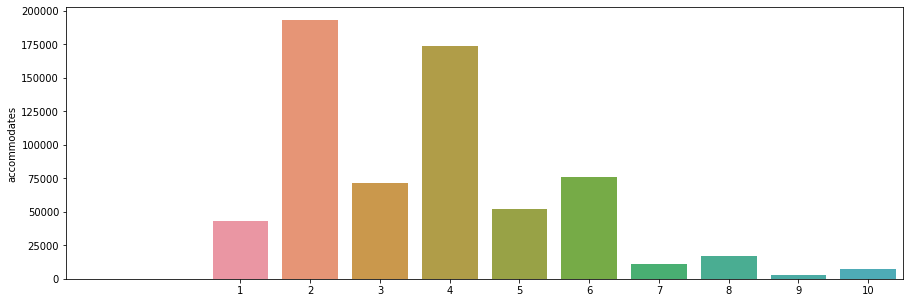

In [28]:
diagrama_caixa(df_airbnb['accommodates'])
grafico_barra(df_airbnb['accommodates'])

In [29]:
df_airbnb, linhas_removidas = excluir_outliers(df_airbnb, 'accommodates')
print('{} linhas removidas'.format(linhas_removidas))

13146 linhas removidas


- Pelo mesmo motivo do "host_listings_count", pode-se excluir os outliers dessa coluna porque apartamentos que acomodam mais de 9 pessoas não são o foco, o objetivo aqui é para imóveis comuns.

- Caso a fosse necessário incluir apartamentos de alto padrão, poderia ser mantida essa variável ou então ser construído um modelo só focado em imóveis com mais de 9 hóspedes

### bathrooms
- Esta feature apresenta o número total de banheiros por imóvel cadastrado

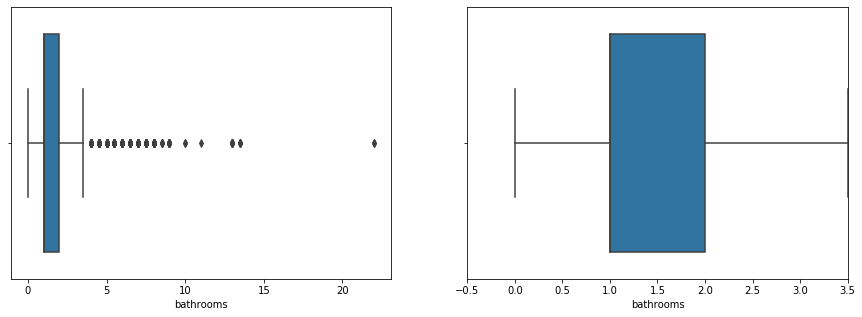

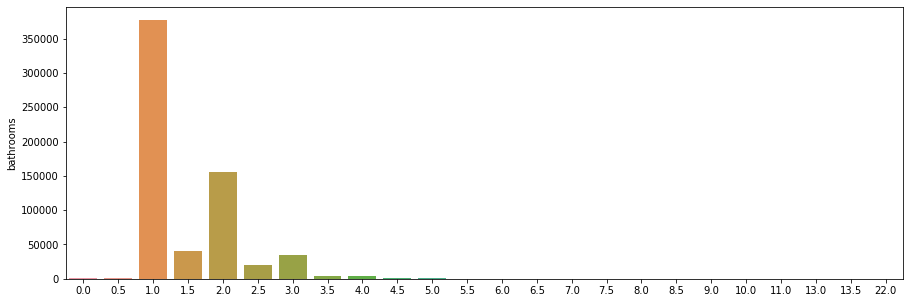

In [30]:
diagrama_caixa(df_airbnb['bathrooms'])
plt.figure(figsize=(15, 5))
sns.barplot(x=df_airbnb['bathrooms'].value_counts().index, y=df_airbnb['bathrooms'].value_counts())

In [31]:
df_airbnb, linhas_removidas = excluir_outliers(df_airbnb, 'bathrooms')
print('{} linhas removidas'.format(linhas_removidas))

6894 linhas removidas


- Outliers podem ser removidos desta variável pelos mesmos motivos anteriores.

### bedrooms
- Esta feature mostra a quantidade de quartos por imóvel

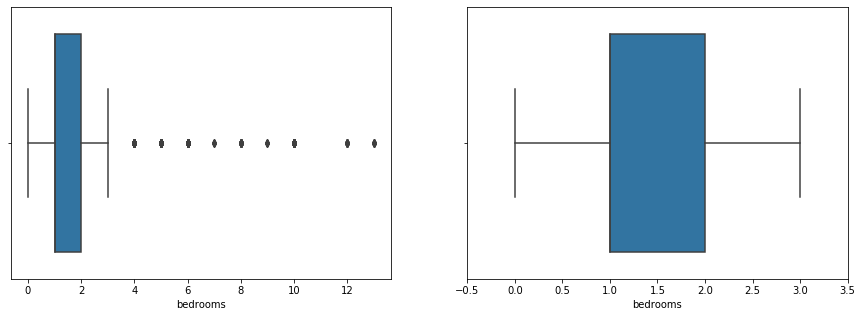

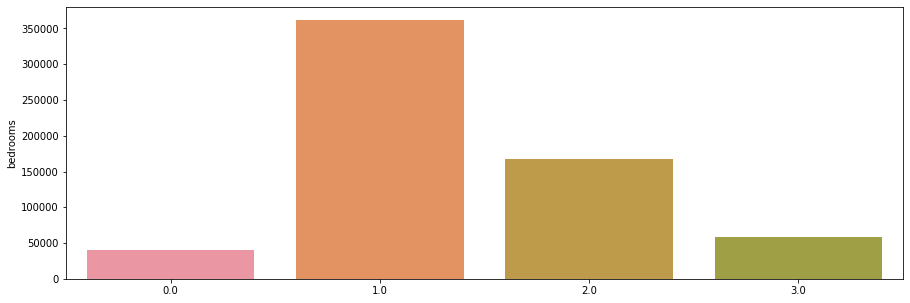

In [32]:
diagrama_caixa(df_airbnb['bedrooms'])
grafico_barra(df_airbnb['bedrooms'])

In [33]:
df_airbnb, linhas_removidas = excluir_outliers(df_airbnb, 'bedrooms')
print('{} linhas removidas'.format(linhas_removidas))

5482 linhas removidas


### beds
- Esta feature mostra a quantidade de camas por imóvel.

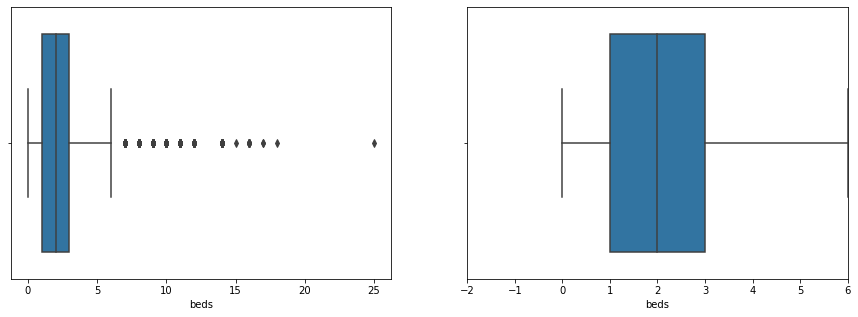

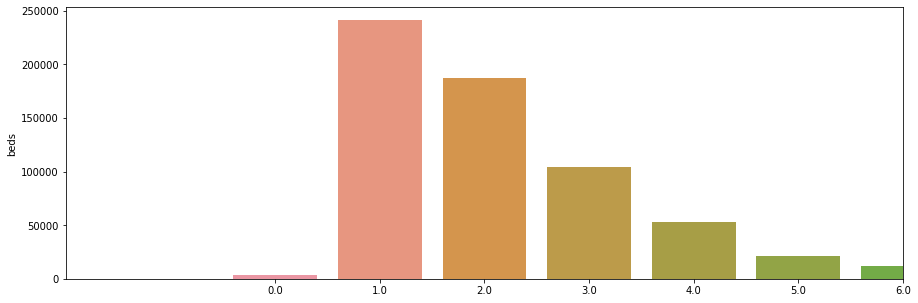

In [34]:
diagrama_caixa(df_airbnb['beds'])
grafico_barra(df_airbnb['beds'])

In [35]:
df_airbnb, linhas_removidas = excluir_outliers(df_airbnb, 'beds')
print('{} linhas removidas'.format(linhas_removidas))

5622 linhas removidas


### minimum_nights
- Esta feature mostra o mínimo de noites possível para alugar um imóvel

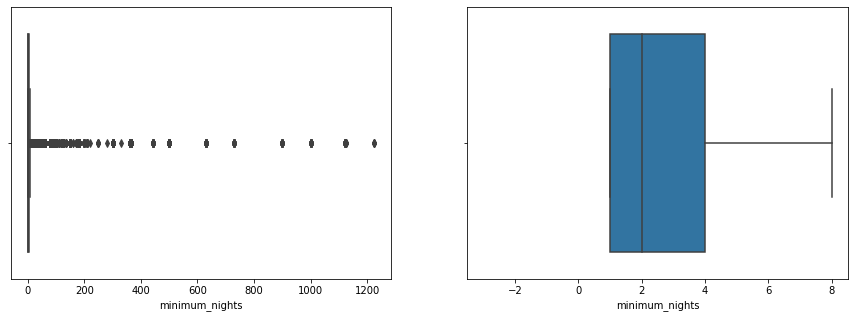

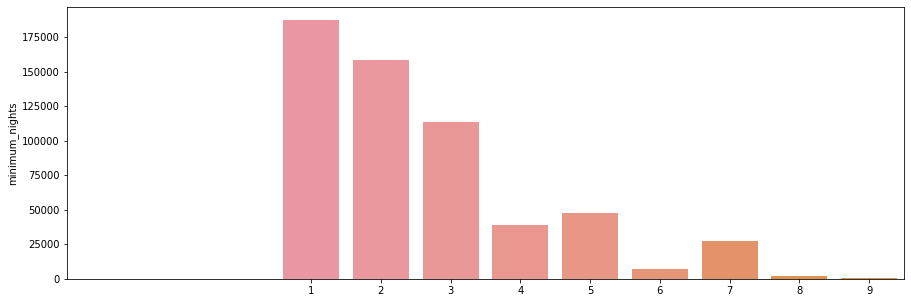

In [36]:
diagrama_caixa(df_airbnb['minimum_nights'])
grafico_barra(df_airbnb['minimum_nights'])

In [37]:
df_airbnb, linhas_removidas = excluir_outliers(df_airbnb, 'minimum_nights')
print('{} linhas removidas'.format(linhas_removidas))

40383 linhas removidas


- Aqui há um motivo talvez até mais forte para excluir esses apartamentos da análise.

- Estamos querendo um modelo que ajude a precificar apartamentos comuns como uma pessoa comum gostaria de disponibilizar. No caso, apartamentos com mais de 8 noites como o "mínimo de noites" podem ser apartamentos de temporada ou ainda apartamentos para morar, em que o host exige pelo menos 1 mês no apartamento.

- Por isso, pode-se excluir os outliers dessa coluna

### maximum_nights
- Esta feature mostra o máximo de noite que o inquilino pode ficar

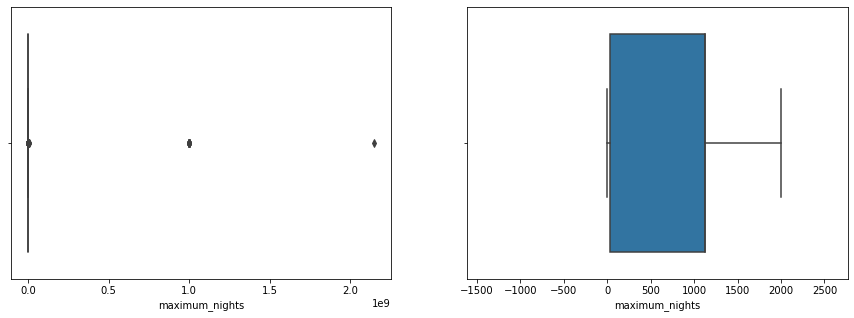

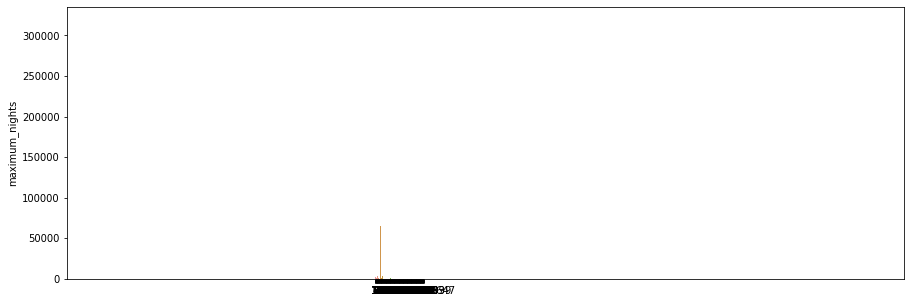

In [38]:
diagrama_caixa(df_airbnb['maximum_nights'])
grafico_barra(df_airbnb['maximum_nights'])

- Essa coluna não parece que vai ajudar na análise.

- Isso porque parece que quase todos os hosts não preenchem esse campo de maximum nights, então ele não parece que vai ser um fator relevante.

- É melhor excluir essa coluna da análise

In [39]:
df_airbnb = df_airbnb.drop('maximum_nights', axis=1)
df_airbnb.shape

(581983, 23)

### number_of_reviews            
- Esta feature mostra o total de reviews que cada hoste tem

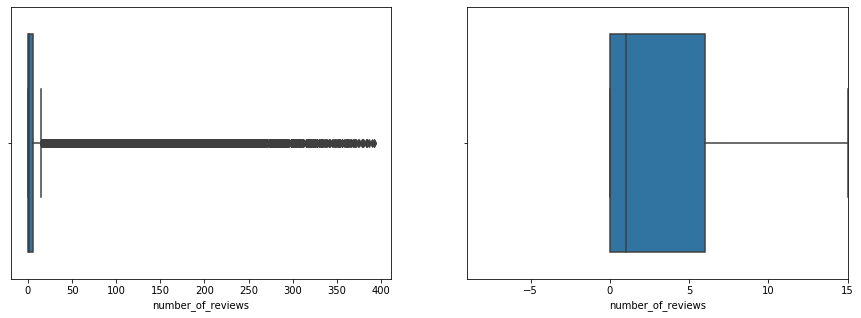

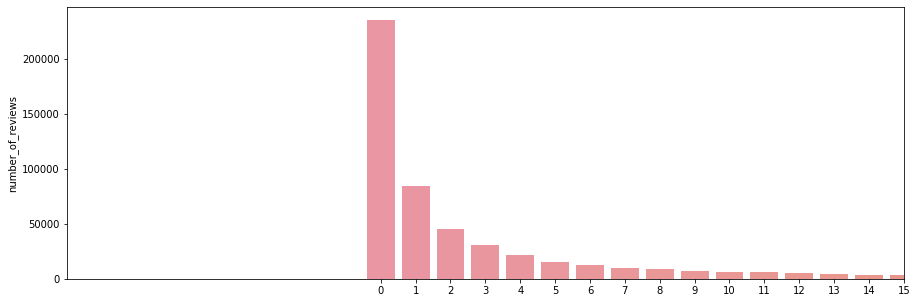

In [40]:
diagrama_caixa(df_airbnb['number_of_reviews'])
grafico_barra(df_airbnb['number_of_reviews'])

- Aqui pode-se tomar algumas decisões diferentes. Eu vou tomar uma decisão baseado na minha análise pessoal de tirar essa característica da análise por alguns motivos:

    1. Se excluir os outliers, vão ser excluídas as pessoas que têm a maior quantidade de reviews (o que normalmente são os hosts que têm mais aluguel). Isso pode impactar muito negativamente o nosso modelo
    2. Pensando no objetivo do modelo, se eu tenho um imóvel parado e quero colocar meu imóvel lá, é claro que eu não tenho review nenhuma. Então talvez tirar essa característica da análise pode na verdade acabar ajudando.
    3. Particularmente tenho dúvida se essa característica deveria impactar ou não o preço final

In [41]:
df_airbnb = df_airbnb.drop('number_of_reviews', axis=1)
df_airbnb.shape

(581983, 22)

### Tratamento de Colunas de Valores de Texto

### - property_type 
- Esta variá vel mostra o tipo de propriedade a ser alugada

Apartment                 458354
House                      51387
Condominium                26456
Serviced apartment         12671
Loft                       12352
Guest suite                 3621
Bed and breakfast           3472
Hostel                      2665
Guesthouse                  2155
Other                       1957
Villa                       1294
Townhouse                    969
Aparthotel                   693
Chalet                       481
Earth house                  468
Tiny house                   457
Boutique hotel               447
Hotel                        376
Casa particular (Cuba)       298
Cottage                      230
Bungalow                     207
Dorm                         185
Cabin                        141
Nature lodge                 124
Castle                        80
Treehouse                     76
Island                        54
Boat                          53
Hut                           40
Campsite                      34
Resort    

C:\Users\gabri\Anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


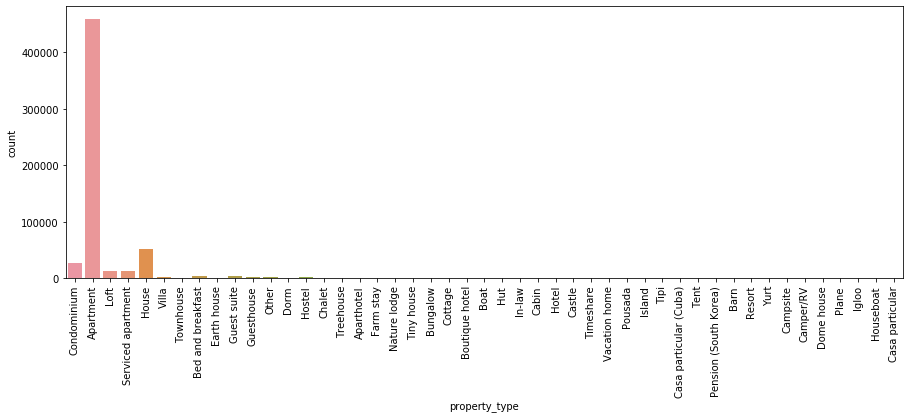

In [42]:
print(df_airbnb['property_type'].value_counts())

plt.figure(figsize=(15, 5))
grafico = sns.countplot('property_type', data=df_airbnb)
grafico.tick_params(axis='x', rotation=90)

- Aqui a o tipo de ação não será "excluir outliers", mas sim agrupar valores que são muito pequenos.

- Todos os tipos de propriedade que têm menos de 2.000 propriedades na base de dados, eu vou agrupar em um grupo chamado "outros". Acho que isso vai facilitar o modelo

['Other', 'Villa', 'Townhouse', 'Aparthotel', 'Chalet', 'Earth house', 'Tiny house', 'Boutique hotel', 'Hotel', 'Casa particular (Cuba)', 'Cottage', 'Bungalow', 'Dorm', 'Cabin', 'Nature lodge', 'Castle', 'Treehouse', 'Island', 'Boat', 'Hut', 'Campsite', 'Resort', 'Camper/RV', 'Yurt', 'Tent', 'Tipi', 'Barn', 'Farm stay', 'Pension (South Korea)', 'Dome house', 'In-law', 'Igloo', 'Vacation home', 'Pousada', 'Houseboat', 'Timeshare', 'Casa particular', 'Plane']


C:\Users\gabri\Anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Apartment             458354
House                  51387
Condominium            26456
Serviced apartment     12671
Loft                   12352
Outros                  8850
Guest suite             3621
Bed and breakfast       3472
Hostel                  2665
Guesthouse              2155
Name: property_type, dtype: int64


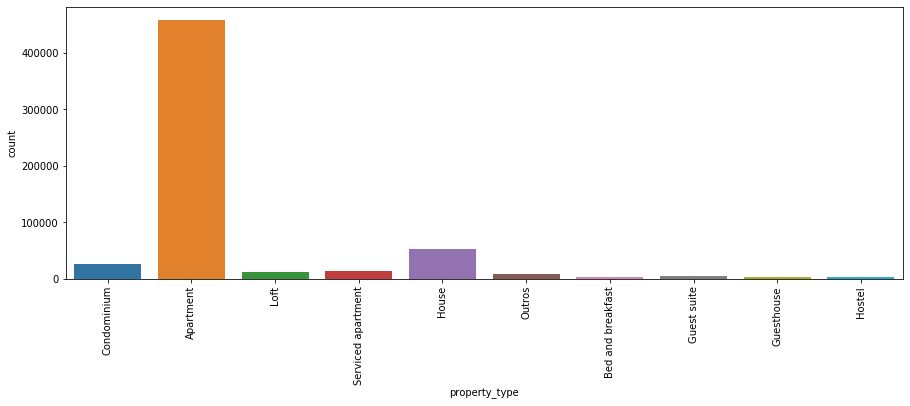

In [43]:
tabela_tipos_casa = df_airbnb['property_type'].value_counts()
colunas_agrupar = []

for tipo in tabela_tipos_casa.index:
    if tabela_tipos_casa[tipo] < 2000:
        colunas_agrupar.append(tipo)
print(colunas_agrupar)

for tipo in colunas_agrupar:
    df_airbnb.loc[df_airbnb['property_type']==tipo, 'property_type'] = 'Outros'

print(df_airbnb['property_type'].value_counts())
plt.figure(figsize=(15, 5))
grafico = sns.countplot('property_type', data=df_airbnb)
grafico.tick_params(axis='x', rotation=90)

### - room_type 
- Esta feature mostra os tipos de quarto disposníveis nas propriedades

Entire home/apt    372443
Private room       196859
Shared room         11714
Hotel room            967
Name: room_type, dtype: int64


C:\Users\gabri\Anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


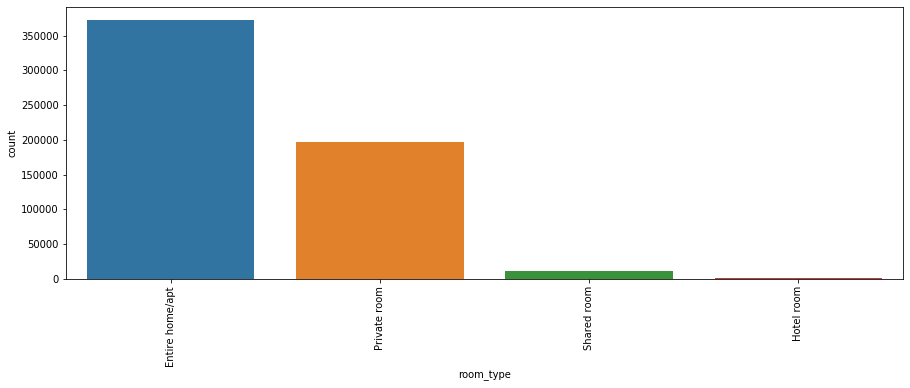

In [44]:
print(df_airbnb['room_type'].value_counts())

plt.figure(figsize=(15, 5))
grafico = sns.countplot('room_type', data=df_airbnb)
grafico.tick_params(axis='x', rotation=90)

### - bed_type 
- Esta feature apresenta os tipos de cama disponíveis nas propriedades

Real Bed         570643
Pull-out Sofa      8055
Futon              1634
Airbed             1155
Couch               496
Name: bed_type, dtype: int64


C:\Users\gabri\Anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


['Pull-out Sofa', 'Futon', 'Airbed', 'Couch']
Real Bed    570643
Outros       11340
Name: bed_type, dtype: int64


C:\Users\gabri\Anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


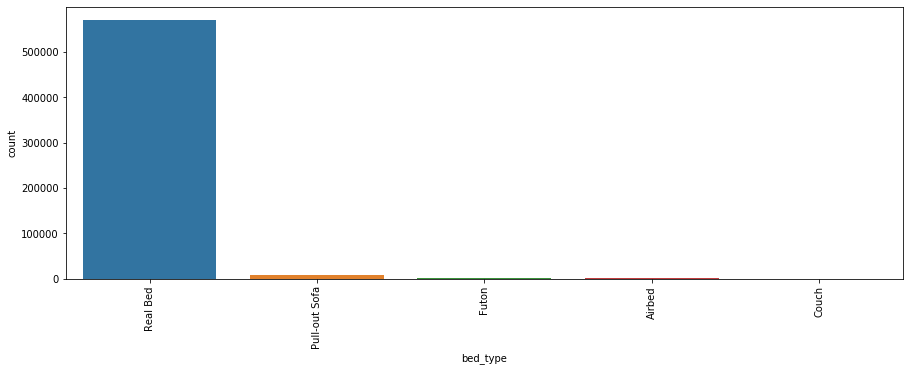

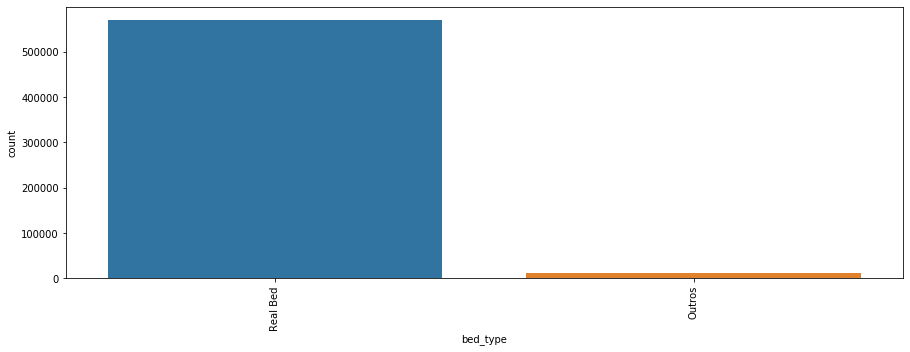

In [45]:
print(df_airbnb['bed_type'].value_counts())

plt.figure(figsize=(15, 5))
grafico = sns.countplot('bed_type', data=df_airbnb)
grafico.tick_params(axis='x', rotation=90)

# agrupando categorias de bed_type
tabela_bed = df_airbnb['bed_type'].value_counts()
colunas_agrupar = []

for tipo in tabela_bed.index:
    if tabela_bed[tipo] < 10000:
        colunas_agrupar.append(tipo)
print(colunas_agrupar)

for tipo in colunas_agrupar:
    df_airbnb.loc[df_airbnb['bed_type']==tipo, 'bed_type'] = 'Outros'

print(df_airbnb['bed_type'].value_counts())
plt.figure(figsize=(15, 5))
grafico = sns.countplot('bed_type', data=df_airbnb)
grafico.tick_params(axis='x', rotation=90)

- Aqui a ação não será "excluir outliers", mas sim agrupar valores que são muito pequenos.

- Como temos 1 valor claramente MUITO maior do que todos os outros, vou criar apenas 2 grupos de camas: "Real Bed" e "outros"


### - cancellation_policy 
- Esta feature mostra as diferentes políticas de cancelamento acionadas por cada host

flexible                       258096
strict_14_with_grace_period    200743
moderate                       113281
strict                           9696
super_strict_60                   135
super_strict_30                    32
Name: cancellation_policy, dtype: int64


C:\Users\gabri\Anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


['strict', 'super_strict_60', 'super_strict_30']
flexible                       258096
strict_14_with_grace_period    200743
moderate                       113281
strict                           9863
Name: cancellation_policy, dtype: int64


C:\Users\gabri\Anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


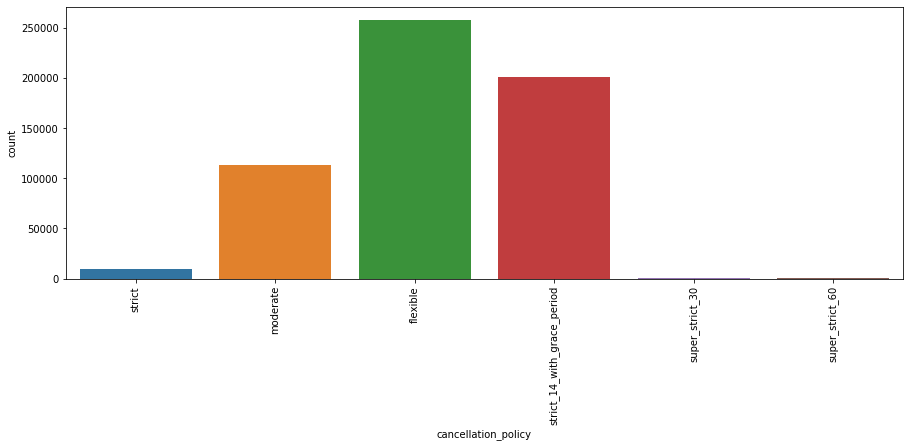

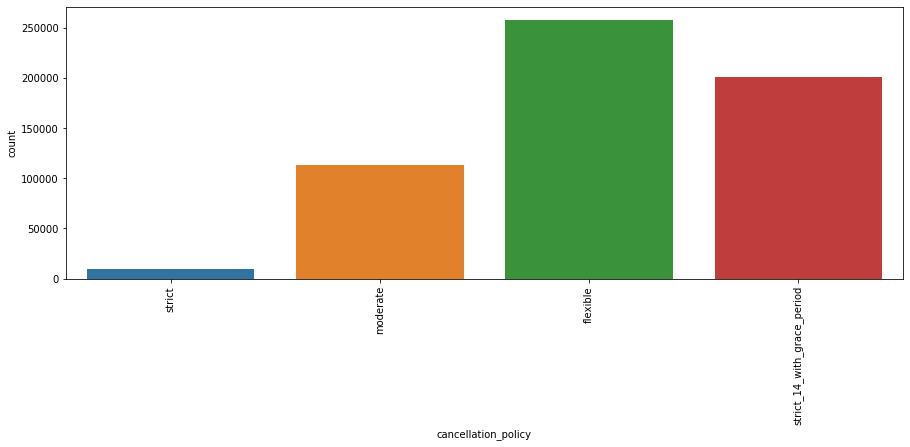

In [48]:
print(df_airbnb['cancellation_policy'].value_counts())

plt.figure(figsize=(15, 5))
grafico = sns.countplot('cancellation_policy', data=df_airbnb)
grafico.tick_params(axis='x', rotation=90)

# agrupando categorias de cancellation_pollicy
tabela_cancellation = df_airbnb['cancellation_policy'].value_counts()
colunas_agrupar = []

for tipo in tabela_cancellation.index:
    if tabela_cancellation[tipo] < 10000:
        colunas_agrupar.append(tipo)
print(colunas_agrupar)

for tipo in colunas_agrupar:
    df_airbnb.loc[df_airbnb['cancellation_policy']==tipo, 'cancellation_policy'] = 'strict'

print(df_airbnb['cancellation_policy'].value_counts())
plt.figure(figsize=(15, 5))
grafico = sns.countplot('cancellation_policy', data=df_airbnb)
grafico.tick_params(axis='x', rotation=90)

### - amenities 

Como temos uma diversidade muito grande de amenities e, às vezes, as mesmas amenities podem ser escritas de forma diferente, o melhor será avaliar a quantidade de amenities como o parâmetro para o nosso modelo.

In [49]:
print(df_airbnb['amenities'].iloc[1].split(','))
print(len(df_airbnb['amenities'].iloc[1].split(',')))

df_airbnb['n_amenities'] = df_airbnb['amenities'].str.split(',').apply(len)

['{TV', '"Cable TV"', 'Internet', 'Wifi', '"Air conditioning"', 'Kitchen', 'Doorman', 'Elevator', '"Buzzer/wireless intercom"', '"Family/kid friendly"', 'Hangers', '"Hair dryer"', 'Iron', '"Laptop friendly workspace"}']
14


In [50]:
df_airbnb = df_airbnb.drop('amenities', axis=1)
df_airbnb.shape

(581983, 22)

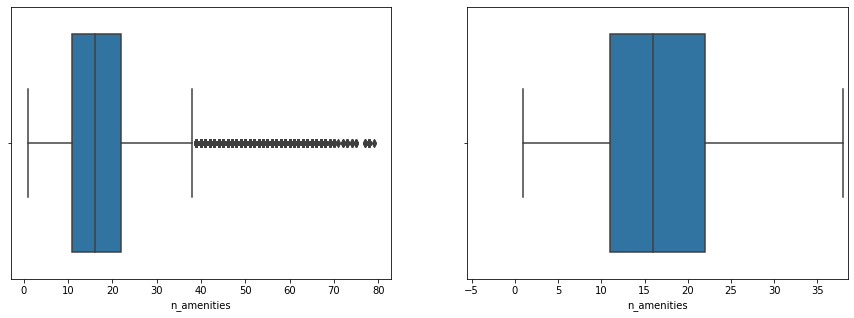

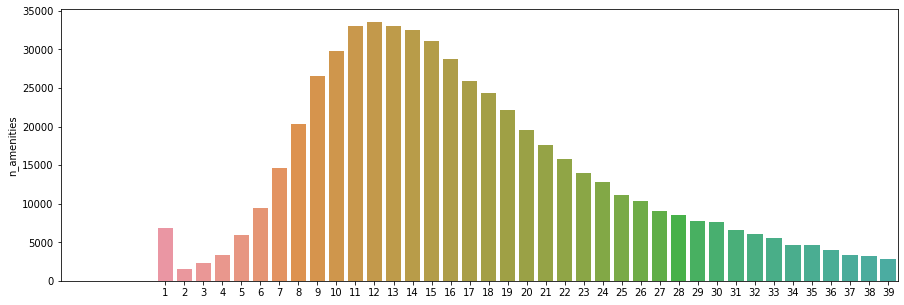

In [51]:
diagrama_caixa(df_airbnb['n_amenities'])
grafico_barra(df_airbnb['n_amenities'])

- Então, essa virou uma coluna de valor numérico e, como todas as outras colunas de valores numéricos, eu exclui outliers com os mesmos modelos anteriores

In [52]:
df_airbnb, linhas_removidas = excluir_outliers(df_airbnb, 'n_amenities')
print('{} linhas removidas'.format(linhas_removidas))

24343 linhas removidas


### Visualização de Mapa das Propriedades

- A intenção é criar um mapa que exiba um pedaço aleatório da base de dados (50.000 propriedades) para ver como as propriedades estão distribuídas pela cidade e também identificar os locais de maior preço 

In [53]:
import plotly.express as px

In [54]:
amostra = df_airbnb.sample(n=50000)
centro_mapa = {'lat':amostra.latitude.mean(), 'lon':amostra.longitude.mean()}
mapa = px.density_mapbox(amostra, lat='latitude', lon='longitude',z='price', radius=2.5,
                        center=centro_mapa, zoom=10,
                        mapbox_style='stamen-terrain')
mapa.show()

### Encoding

##### Precisamos ajustar as features para facilitar o trabalho do modelo futuro (features de categoria, true e false, etc.)

- Features de Valores True ou False, vamos substituir True por 1 e False por 0.
- Features de Categoria (features em que os valores da coluna são textos) vamos utilizar o método de encoding de variáveis dummies

In [66]:
colunas_tf = ['host_is_superhost', 'instant_bookable', 'is_business_travel_ready', 'host_identity_verified']
df_airbnb_cod = df_airbnb.copy()
for coluna in colunas_tf:
    df_airbnb_cod.loc[df_airbnb_cod[coluna]=='t', coluna] = 1
    df_airbnb_cod.loc[df_airbnb_cod[coluna]=='f', coluna] = 0

In [67]:
colunas_categorias = ['property_type', 'room_type', 'bed_type', 'cancellation_policy']
df_airbnb_cod = pd.get_dummies(data=df_airbnb_cod, columns=colunas_categorias)
display(df_airbnb_cod.head())

host_is_superhost  host_listings_count host_identity_verified   latitude  \
1                 1                  2.0                      0 -22.965919   
3                 0                  3.0                      1 -22.977117   
4                 1                  1.0                      1 -22.983024   
5                 1                  1.0                      1 -22.988165   
6                 1                  1.0                      1 -22.981269   

   longitude  accommodates  bathrooms  bedrooms  beds  price  ...  \
1 -43.178962             5        1.0       2.0   2.0  270.0  ...   
3 -43.190454             3        1.0       1.0   2.0  161.0  ...   
4 -43.214270             3        1.0       1.0   2.0  222.0  ...   
5 -43.193588             3        1.5       1.0   2.0  308.0  ...   
6 -43.190457             2        1.0       1.0   2.0  219.0  ...   

   room_type_Entire home/apt  room_type_Hotel room  room_type_Private room  \
1                          1                     0                       0   
3                          1                     0                       0   
4                          1                     0                       0   
5                          1                     0                       0   
6                          1                     0                       0   

  room_type_Shared room bed_type_Outros  bed_type_Real Bed  \
1                     0               0                  1   
3                     0               0                  1   
4                     0               0                  1   
5                     0               0                  1   
6                     0               0                  1   

   cancellation_policy_flexible  cancellation_policy_moderate  \
1                             0                             0   
3                             0                             0   
4                             0                             0   
5                             0                             0   
6                             0                             0   

   cancellation_policy_strict  cancellation_policy_strict_14_with_grace_period  
1                           1                                                0  
3                           1                                                0  
4                           1                                                0  
5                           1                                                0  
6                           1                                                0  

[5 rows x 38 columns]

### Modelo de Previsão

- Métricas de Avaliação

Vamos usar aqui o R² que vai dizer o quão bem o modelo consegue explicar o preço. Isso seria um ótimo parâmetro para ver o quão bom é o modelo <br>
-> Quanto mais próximo de 100%, melhor

Vou calcular também o Erro Quadrático Médio, que vai mostrar para gente o quanto o modelo está errando. <br>
-> Quanto menor for o erro, melhor

In [68]:
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.model_selection import train_test_split

In [69]:
def avaliar_modelo(nome_modelo, y_teste, previsao):
    r2 = r2_score(y_teste, previsao)
    RSME = np.sqrt(mean_squared_error(y_teste, previsao))
    return f'Modelo {nome_modelo}:\nR²:{r2:.2%}\nRSME:{RSME:.2f}'

- Modelos a Serem Testados
    1. RandomForest
    2. LinearRegression
    3. Extra Tree
    
Esses são alguns dos modelos que existem para fazer previsão de valores numéricos (o que chamamos de regressão). Estamos querendo calcular o preço, portanto, queremos prever um valor numérico.

Assim, foram escolhidos esses 3 modelos.

Certamente existem muito outros modelos para previsão de variáveis discretas, mas, na dúvida, esses 3 modelos que são usados aqui são bons para muitos problemas de Regressão.

In [70]:
modelo_rf = RandomForestRegressor()
modelo_lr = LinearRegression()
modelo_et = ExtraTreesRegressor()

modelos = {'RandomForest': modelo_rf,
          'LinearRegression': modelo_lr,
          'ExtraTrees': modelo_et,
          }

y = df_airbnb_cod['price']
X = df_airbnb_cod.drop('price', axis=1)

- Separação dos dados em treino e teste + Treino do Modelo

Os modelos aprendem com o que chamamos de treino.

Basicamente o que se faz é: separam-se as informações em treino e teste, ex: 20% da base de dados vai servir para teste e 80% para treino.

Então, é dados para o modelo os dados de treino, ele vai olhar aqueles dados e aprender a prever os preços.

Depois que ele aprende, faz-se um teste com ele, com os dados de teste, para ver se ela está bom ou não. Analisando os dados de teste é que se descobre o melhor modelo

In [71]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=10)

for nome_modelo, modelo in modelos.items():
    #treinar
    modelo.fit(X_train, y_train)
    #testar
    previsao = modelo.predict(X_test)
    print(avaliar_modelo(nome_modelo, y_test, previsao))

Modelo RandomForest:
R²:97.25%
RSME:44.00
Modelo LinearRegression:
R²:33.07%
RSME:216.95
Modelo ExtraTrees:
R²:97.60%
RSME:41.10


- Melhor Modelo: ExtraTressRegressor

    Esse foi o modelo com maior valor de R² e ao mesmo tempo o menor valor de RSME. Como não houve uma grande diferença de velocidade de treino e de previsão desse modelo com o modelo de RandomForest (que teve resultados próximos de R² e RSME), vamos escolher o Modelo ExtraTrees.
    
    O modelo de regressão linear não obteve um resultado satisfatório, com valores de R² e RSME muito piores do que os outros 2 modelos.
    
- Resultados das Métricas de Avaliação no modelo escolhido:<br>
Modelo ExtraTrees:<br>
R²:97.49%<br>
RSME:41.99

### Análise do Melhor Modelo

0
bedrooms                                         0.102452
latitude                                         0.096403
longitude                                        0.093068
n_amenities                                      0.081364
extra_people                                     0.079576
bathrooms                                        0.077427
accommodates                                     0.070917
room_type_Entire home/apt                        0.069586
minimum_nights                                   0.063608
beds                                             0.049657
host_listings_count                              0.037863
guests_included                                  0.021672
instant_bookable                                 0.021469
host_identity_verified                           0.020785
cancellation_policy_flexible                     0.019551
property_type_Apartment                          0.012662
host_is_superhost                                0.012551
cancellation_policy_moderate                     0.012242
ano                                              0.010396
cancellation_policy_strict_14_with_grace_period  0.007891
property_type_House                              0.007139
property_type_Condominium                        0.005115
mes                                              0.004491
room_type_Private room                           0.003790
bed_type_Real Bed                                0.002637
bed_type_Outros                                  0.002577
property_type_Outros                             0.002354
property_type_Serviced apartment                 0.002224
property_type_Loft                               0.002124
room_type_Shared room                            0.001843
property_type_Bed and breakfast                  0.001271
property_type_Guesthouse                         0.000882
cancellation_policy_strict                       0.000818
property_type_Hostel                             0.000646
property_type_Guest suite                        0.000634
room_type_Hotel room                             0.000313
is_business_travel_ready                         0.000000

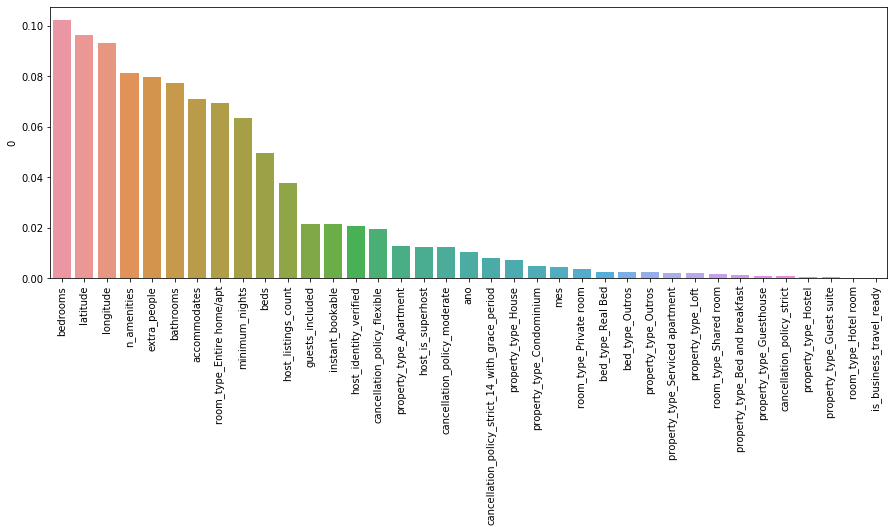

In [73]:
#print(modelo_et.feature_importances_)
#print(X_train.columns)
importancia_features = pd.DataFrame(modelo_et.feature_importances_, X_train.columns)
importancia_features = importancia_features.sort_values(by=0, ascending=False)
display(importancia_features)
plt.figure(figsize=(15, 5))
ax = sns.barplot(x=importancia_features.index, y=importancia_features[0])
ax.tick_params(axis='x', rotation=90)

### Ajustes e Melhorias no Melhor Modelo

### Ajustes Finais no Modelo

- is_business_travel ready não parece ter muito impacto no modelo. Por isso, para chegar em um modelo mais simples, vamos excluir essa feature e testar o modelo sem ela.

In [74]:
df_airbnb_cod = df_airbnb_cod.drop('is_business_travel_ready', axis=1)

y = df_airbnb_cod['price']
X = df_airbnb_cod.drop('price', axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=10)

modelo_et.fit(X_train, y_train)
previsao = modelo_et.predict(X_test)
print(avaliar_modelo('ExtraTrees', y_test, previsao))

Modelo ExtraTrees:
R²:97.57%
RSME:41.32


In [77]:
df_teste = df_airbnb_cod.copy()
for coluna in df_teste:
    if 'bed_type' in coluna:    
        df_teste = df_teste.drop(coluna, axis=1)
print(df_teste.columns)
y = df_teste['price']
X = df_teste.drop('price', axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=10)

modelo_et.fit(X_train, y_train)
previsao = modelo_et.predict(X_test)
print(avaliar_modelo('ExtraTrees', y_test, previsao))

Index(['host_is_superhost', 'host_listings_count', 'host_identity_verified',
       'latitude', 'longitude', 'accommodates', 'bathrooms', 'bedrooms',
       'beds', 'price', 'guests_included', 'extra_people', 'minimum_nights',
       'instant_bookable', 'ano', 'mes', 'n_amenities',
       'property_type_Apartment', 'property_type_Bed and breakfast',
       'property_type_Condominium', 'property_type_Guest suite',
       'property_type_Guesthouse', 'property_type_Hostel',
       'property_type_House', 'property_type_Loft', 'property_type_Outros',
       'property_type_Serviced apartment', 'room_type_Entire home/apt',
       'room_type_Hotel room', 'room_type_Private room',
       'room_type_Shared room', 'cancellation_policy_flexible',
       'cancellation_policy_moderate', 'cancellation_policy_strict',
       'cancellation_policy_strict_14_with_grace_period'],
      dtype='object')
Modelo ExtraTrees:
R²:97.58%
RSME:41.24
